In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# Remember that wcword is different from word or token in usual sense! 
!man wc|grep -A 2 -B 1 "A word is"

DESCRIPTION
       Print  newline,  word, and byte counts for each FILE, and a total line if more than one FILE is specified.  A word is a non-zero-length sequence of characters delimited by white
       space.



# Load data

In [3]:

def load_lang_stat(stats_dir):
    df = pd.read_csv(Path(stats_dir)/'stats.tsv', sep='\t')
    df['crawl'] = str(stats_dir)
    return df

def add_total(df):
    total = df.sum(numeric_only=True, axis=0).to_frame().T
    total.loc[:,'lang'] = 'TOTAL'
    total.loc[:,'crawl'] = next(iter(df['crawl'].unique()))
    df = pd.concat([total,df], ignore_index=True)
    return df

ldfs = {d.name: add_total(load_lang_stat(d)) 
                 for d in Path('.').glob('*release*stats') if d.is_dir()}

next(iter(ldfs.values()))

,text_newlines,text_wcwords,text_chars,text_bytes,docs,lang,crawl
0,613308414835,7581053828821,52004660650575,67421579534647,20620090001,TOTAL,release2.0_collections_merged_stats
1,825077,3348713,25689522,28542495,11667,ace_Arab,release2.0_collections_merged_stats
2,44949744,172750790,1585989859,1645020458,1257535,ace_Latn,release2.0_collections_merged_stats
3,251519794,2425634067,18352201435,18550086567,9589394,afr_Latn,release2.0_collections_merged_stats
4,304294712,4372079575,28416802362,30091668721,11291570,als_Latn,release2.0_collections_merged_stats
...,...,...,...,...,...,...,...
189,131064015,235766941,2266049229,4147641118,3772042,yue_Hant,release2.0_collections_merged_stats
190,76745471229,149309615501,3665438918192,9331431730742,2713235166,zho_Hans,release2.0_collections_merged_stats
191,7818212137,17313596242,417513998557,1034607887738,321270354,zho_Hant,release2.0_collections_merged_stats
192,3106520966,28661990213,193523621046,195624061420,69227648,zsm_Latn,release2.0_collections_merged_stats


In [4]:
def load_lang_stat_mr(stats_dir):
    df = pd.read_csv(Path(stats_dir)/'stats.tsv', sep='\t', header=None, 
                     names=['index','text_newlines','text_wcwords','text_chars','docs'])
    df[['crawl','lang']] = df['index'].str.split(',', expand=True)
    df['text_bytes'] = 0
    df.drop(columns='index', inplace=True)
    return df

In [5]:
def rename_crawl(df, crawl):
    df.crawl = crawl
    return df


ldfs.update({'release1_' + d.name.split('_')[0]: rename_crawl(add_total(load_lang_stat_mr(d)), 'release1_' + d.name.split('_')[0])
                 for d in Path('.').glob('*filtered_stats_mr') if d.is_dir()})


In [6]:
qdf = load_lang_stat_mr('./release2.0_html_stage2_stats_mr/')

In [7]:
ldfs.update({'release2.0_'+c.replace('CC-MAIN-2022-40', 'cc40'): 
             rename_crawl(add_total(qdf[qdf.crawl==c].copy()), 'release2.0_'+c.replace('CC-MAIN-2022-40', 'cc40')) 
             for c in ('wide00015','wide00017','CC-MAIN-2022-40')})

In [8]:
total_df = pd.concat([v[v.lang=='TOTAL'] for k,v in ldfs.items()], ignore_index=True).drop(columns='lang').set_index('crawl')
total_df *= 1.0
total_df.sort_values(by='crawl').to_csv('_release1vs2/TOTALs.tsv', float_format="%.2e", sep='\t')
!column -t _release1vs2/TOTALs.tsv

crawl                                text_newlines  text_wcwords  text_chars  text_bytes  docs
release1.2_cleaned_stats             5.66e+11       4.21e+12      3.19e+13    4.27e+13    3.39e+09
release1.2_dedup_stats               9.84e+11       5.56e+12      4.15e+13    5.41e+13    5.25e+09
release1_cc40                        4.69e+11       2.46e+12      1.68e+13    0.00e+00    2.81e+09
release1_deduped_stats               1.11e+12       5.64e+12      4.05e+13    5.01e+13    5.25e+09
release1_stats                       5.40e+12       2.17e+13      1.51e+14    1.94e+14    2.89e+10
release1_wide00015                   1.08e+12       4.90e+12      3.26e+13    0.00e+00    5.12e+09
release1_wide00017                   1.18e+12       4.70e+12      3.48e+13    0.00e+00    1.04e+10
release2.0_annotated_stats           6.13e+11       7.58e+12      5.20e+13    6.74e+13    2.06e+10
release2.0_cc40                      6.48e+10       9.41e+11      6.76e+12    0.00e+00    3.12e+09
release2.0_cle

# Load language mapping

In [9]:
linf = pd.read_csv('./_langs/langs_HPLTv2.tsv', sep='\t')
linf

,v2 Language Code (ISO 693-3+script),Language Name,ISO693-3 code,ISO693-3 code macro,ISO693-1 direct code,ISO693-1 through macro
0,ace_Arab,Achinese,ace,NaN,NaN,NaN
1,ace_Latn,Achinese,ace,NaN,NaN,NaN
2,afr_Latn,Afrikaans,afr,NaN,af,af
3,als_Latn,Tosk Albanian,als,sqi,NaN,sq
4,amh_Ethi,Amharic,amh,NaN,am,am
...,...,...,...,...,...,...
188,yue_Hant,Yue Chinese,yue,zho,NaN,zh
189,zho_Hans,Chinese,zho,NaN,zh,zh
190,zho_Hant,Chinese,zho,NaN,zh,zh
191,zsm_Latn,Standard Malay,zsm,msa,NaN,ms


##### There are several new codes for some old ones, but a single old code for each new one

In [10]:
linf['ISO693-1 direct code'].value_counts().head()

zh    2
ks    2
af    1
pa    1
sm    1
Name: ISO693-1 direct code, dtype: int64

In [11]:
linf[linf['ISO693-1 direct code']=='az']

,v2 Language Code (ISO 693-3+script),Language Name,ISO693-3 code,ISO693-3 code macro,ISO693-1 direct code,ISO693-1 through macro


In [12]:
assert linf['v2 Language Code (ISO 693-3+script)'].value_counts().max()==1, linf['v2 Language Code (ISO 693-3+script)'].value_counts()

In [13]:
new2old = linf.set_index('v2 Language Code (ISO 693-3+script)')['ISO693-1 direct code'].dropna().to_dict()
new2old['TOTAL'] = 'TOTAL'
new2old

{'afr_Latn': 'af',
 'amh_Ethi': 'am',
 'ara_Arab': 'ar',
 'asm_Beng': 'as',
 'bak_Cyrl': 'ba',
 'bam_Latn': 'bm',
 'bel_Cyrl': 'be',
 'ben_Beng': 'bn',
 'bod_Tibt': 'bo',
 'bos_Latn': 'bs',
 'bul_Cyrl': 'bg',
 'cat_Latn': 'ca',
 'ces_Latn': 'cs',
 'cym_Latn': 'cy',
 'dan_Latn': 'da',
 'deu_Latn': 'de',
 'dzo_Tibt': 'dz',
 'ell_Grek': 'el',
 'eng_Latn': 'en',
 'epo_Latn': 'eo',
 'est_Latn': 'et',
 'eus_Latn': 'eu',
 'ewe_Latn': 'ee',
 'fao_Latn': 'fo',
 'fij_Latn': 'fj',
 'fin_Latn': 'fi',
 'fra_Latn': 'fr',
 'gla_Latn': 'gd',
 'gle_Latn': 'ga',
 'glg_Latn': 'gl',
 'grn_Latn': 'gn',
 'guj_Gujr': 'gu',
 'hat_Latn': 'ht',
 'hau_Latn': 'ha',
 'heb_Hebr': 'he',
 'hin_Deva': 'hi',
 'hrv_Latn': 'hr',
 'hun_Latn': 'hu',
 'hye_Armn': 'hy',
 'ibo_Latn': 'ig',
 'ind_Latn': 'id',
 'isl_Latn': 'is',
 'ita_Latn': 'it',
 'jav_Latn': 'jv',
 'jpn_Jpan': 'ja',
 'kan_Knda': 'kn',
 'kas_Arab': 'ks',
 'kas_Deva': 'ks',
 'kat_Geor': 'ka',
 'kaz_Cyrl': 'kk',
 'khm_Khmr': 'km',
 'kik_Latn': 'ki',
 'kin_Latn':

# Display ratios for two versions

In [14]:
ldfs.keys()

dict_keys(['release2.0_collections_merged_stats', 'release1.2_cleaned_stats', 'release1_deduped_stats', 'release1_stats', 'release1.2_dedup_stats', 'release2.0_annotated_stats', 'release2.0_html_stage2_stats', 'release2.0_cleaned_stats', 'release1_wide00015', 'release1_cc40', 'release1_wide00017', 'release2.0_wide00015', 'release2.0_wide00017', 'release2.0_cc40'])

In [15]:
ldfs['release1_deduped_stats']

,text_newlines,text_wcwords,text_chars,text_bytes,docs,lang,crawl
0,1111691972758,5644440867952,40461841757754,50086127689534,5245836785,TOTAL,release1_deduped_stats
1,448064349,1871362554,13331724243,13475549529,1371732,af,release1_deduped_stats
2,9199928573,51529199558,323491720272,527154118125,46644105,ar,release1_deduped_stats
3,762174849,2944857613,22210490266,25209813882,2999633,az,release1_deduped_stats
4,292202283,1391858297,11412918936,19338568829,1263852,be,release1_deduped_stats
...,...,...,...,...,...,...,...
71,3176621860,18187535686,134141286346,230809447983,17860323,uk,release1_deduped_stats
72,267658190,2018995985,11134738511,16125024258,2230857,ur,release1_deduped_stats
73,92653353,556448432,4376122354,6116559302,633219,uz,release1_deduped_stats
74,9492177775,64973221783,316973571090,391798020201,40100516,vi,release1_deduped_stats


In [16]:
{1,2,3}.difference({1,2,3,4})

set()

In [17]:
rdfs = {} # ratios
for k in ldfs.keys():
    for origin_k in ldfs.keys():
        if k==origin_k: continue
        ldf, oldf = ldfs[k].copy(), ldfs[origin_k].copy()
        
        if k.startswith('release1') and origin_k.startswith('release2'):
            continue
        elif k.startswith('release2') and origin_k.startswith('release1'):
            ldf['olang'] = ldf.lang.apply(lambda l: new2old.get(l)).dropna()        
        else:
            ldf['olang'] = ldf.lang
        
        print(k, origin_k)
        ldf = ldf.set_index('olang')
        oldf = oldf.set_index('lang')

        ldf = ldf[ldf.index.isin(oldf.index)]
        oldf = oldf[oldf.index.isin(ldf.index)]

        # duplicate lines for old langs corresponding for several new langs
        oldf = oldf.merge(ldf.lang, how='inner', left_index=True, right_index=True)  

        oldf.index = oldf.lang + '/' + oldf.index
        ldf.index = ldf.lang + '/' + ldf.index

        for c in ldf.columns:
            if pd.api.types.is_numeric_dtype(ldf[c]):            
                ldf.loc[:,c] = ldf[c] / oldf[c]
        ldf['rank'] = oldf['text_chars'].rank(ascending=False)

        ldf.crawl += '/' + oldf.crawl
        ldf = ldf.reset_index()
        rdfs[f'{k}/{origin_k}'] = ldf

release2.0_collections_merged_stats release1.2_cleaned_stats
release2.0_collections_merged_stats release1_deduped_stats
release2.0_collections_merged_stats release1_stats
release2.0_collections_merged_stats release1.2_dedup_stats
release2.0_collections_merged_stats release2.0_annotated_stats
release2.0_collections_merged_stats release2.0_html_stage2_stats
release2.0_collections_merged_stats release2.0_cleaned_stats
release2.0_collections_merged_stats release1_wide00015
release2.0_collections_merged_stats release1_cc40
release2.0_collections_merged_stats release1_wide00017
release2.0_collections_merged_stats release2.0_wide00015
release2.0_collections_merged_stats release2.0_wide00017
release2.0_collections_merged_stats release2.0_cc40
release1.2_cleaned_stats release1_deduped_stats
release1.2_cleaned_stats release1_stats
release1.2_cleaned_stats release1.2_dedup_stats
release1.2_cleaned_stats release1_wide00015
release1.2_cleaned_stats release1_cc40
release1.2_cleaned_stats release1_wi

/tmp/ipykernel_7532/2145726131.py:29: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  ldf.loc[:,c] = ldf[c] / oldf[c]
/tmp/ipykernel_7532/2145726131.py:29: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  ldf.loc[:,c] = ldf[c] / oldf[c]
/tmp/ipykernel_7532/2145726131.py:29: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  ldf.loc[:,c] = ldf

release1_stats release1_wide00015
release1_stats release1_cc40
release1_stats release1_wide00017
release1.2_dedup_stats release1.2_cleaned_stats
release1.2_dedup_stats release1_deduped_stats
release1.2_dedup_stats release1_stats
release1.2_dedup_stats release1_wide00015
release1.2_dedup_stats release1_cc40
release1.2_dedup_stats release1_wide00017
release2.0_annotated_stats release2.0_collections_merged_stats
release2.0_annotated_stats release1.2_cleaned_stats
release2.0_annotated_stats release1_deduped_stats
release2.0_annotated_stats release1_stats
release2.0_annotated_stats release1.2_dedup_stats
release2.0_annotated_stats release2.0_html_stage2_stats
release2.0_annotated_stats release2.0_cleaned_stats
release2.0_annotated_stats release1_wide00015
release2.0_annotated_stats release1_cc40
release2.0_annotated_stats release1_wide00017
release2.0_annotated_stats release2.0_wide00015
release2.0_annotated_stats release2.0_wide00017
release2.0_annotated_stats release2.0_cc40
release2.0_ht

/tmp/ipykernel_7532/2145726131.py:29: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  ldf.loc[:,c] = ldf[c] / oldf[c]


release2.0_html_stage2_stats release1_wide00017
release2.0_html_stage2_stats release2.0_wide00015
release2.0_html_stage2_stats release2.0_wide00017
release2.0_html_stage2_stats release2.0_cc40
release2.0_cleaned_stats release2.0_collections_merged_stats
release2.0_cleaned_stats release1.2_cleaned_stats
release2.0_cleaned_stats release1_deduped_stats
release2.0_cleaned_stats release1_stats
release2.0_cleaned_stats release1.2_dedup_stats
release2.0_cleaned_stats release2.0_annotated_stats
release2.0_cleaned_stats release2.0_html_stage2_stats
release2.0_cleaned_stats release1_wide00015
release2.0_cleaned_stats release1_cc40
release2.0_cleaned_stats release1_wide00017
release2.0_cleaned_stats release2.0_wide00015
release2.0_cleaned_stats release2.0_wide00017
release2.0_cleaned_stats release2.0_cc40
release1_wide00015 release1.2_cleaned_stats
release1_wide00015 release1_deduped_stats
release1_wide00015 release1_stats
release1_wide00015 release1.2_dedup_stats
release1_wide00015 release1_cc40

/tmp/ipykernel_7532/2145726131.py:29: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  ldf.loc[:,c] = ldf[c] / oldf[c]
/tmp/ipykernel_7532/2145726131.py:29: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  ldf.loc[:,c] = ldf[c] / oldf[c]
/tmp/ipykernel_7532/2145726131.py:29: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  ldf.loc[:,c] = ldf

release1_wide00017 release1_deduped_stats
release1_wide00017 release1_stats
release1_wide00017 release1.2_dedup_stats
release1_wide00017 release1_wide00015
release1_wide00017 release1_cc40
release2.0_wide00015 release2.0_collections_merged_stats
release2.0_wide00015 release1.2_cleaned_stats
release2.0_wide00015 release1_deduped_stats
release2.0_wide00015 release1_stats
release2.0_wide00015 release1.2_dedup_stats
release2.0_wide00015 release2.0_annotated_stats
release2.0_wide00015 release2.0_html_stage2_stats
release2.0_wide00015 release2.0_cleaned_stats
release2.0_wide00015 release1_wide00015
release2.0_wide00015 release1_cc40
release2.0_wide00015 release1_wide00017
release2.0_wide00015 release2.0_wide00017
release2.0_wide00015 release2.0_cc40
release2.0_wide00017 release2.0_collections_merged_stats
release2.0_wide00017 release1.2_cleaned_stats
release2.0_wide00017 release1_deduped_stats
release2.0_wide00017 release1_stats
release2.0_wide00017 release1.2_dedup_stats
release2.0_wide0001

In [18]:
{k: (len(v), v['index'].unique() if 'index' in v.columns else '') for k,v in rdfs.items()}

{'release2.0_collections_merged_stats/release1.2_cleaned_stats': (65,
  array(['TOTAL/TOTAL', 'afr_Latn/af', 'ara_Arab/ar', 'bel_Cyrl/be',
         'ben_Beng/bn', 'bul_Cyrl/bg', 'cat_Latn/ca', 'ces_Latn/cs',
         'cym_Latn/cy', 'dan_Latn/da', 'deu_Latn/de', 'ell_Grek/el',
         'eng_Latn/en', 'epo_Latn/eo', 'est_Latn/et', 'eus_Latn/eu',
         'fin_Latn/fi', 'fra_Latn/fr', 'gle_Latn/ga', 'glg_Latn/gl',
         'guj_Gujr/gu', 'heb_Hebr/he', 'hin_Deva/hi', 'hun_Latn/hu',
         'hye_Armn/hy', 'ind_Latn/id', 'isl_Latn/is', 'ita_Latn/it',
         'jpn_Jpan/ja', 'kan_Knda/kn', 'kat_Geor/ka', 'kaz_Cyrl/kk',
         'kir_Cyrl/ky', 'kor_Hang/ko', 'lit_Latn/lt', 'mal_Mlym/ml',
         'mar_Deva/mr', 'mkd_Cyrl/mk', 'mlt_Latn/mt', 'mya_Mymr/my',
         'nld_Latn/nl', 'nno_Latn/nn', 'nob_Latn/nb', 'pan_Guru/pa',
         'pol_Latn/pl', 'por_Latn/pt', 'ron_Latn/ro', 'rus_Cyrl/ru',
         'sin_Sinh/si', 'slk_Latn/sk', 'slv_Latn/sl', 'som_Latn/so',
         'spa_Latn/es', 'swe_Latn

In [19]:
pdf = pd.concat([v for k,v in rdfs.items()], ignore_index=True)

pdf = pdf.melt(id_vars=['index','lang','crawl', 'rank'])

In [20]:
pdf.crawl = pdf.crawl.str.replace('release','').str.replace('_stats','')
ok = origin_k.replace('release','').replace('_stats','')

In [21]:
print(pdf.variable.unique())
pdf = pdf[pdf.variable.isin('docs text_newlines text_chars'.split())]

['text_newlines' 'text_wcwords' 'text_chars' 'text_bytes' 'docs']


In [22]:
pdf = pdf.sort_values(by=['variable','rank'])

In [23]:
import math
sns.set_style(style='whitegrid')

# TODO: logscale, add raw stats for 1.2_cleaned and sort by it
def plot_ratios(pdf, cats='index', vline=1, log_base=2, row_order=None, height=12, aspect=0.5, save_path=None):
    g = sns.catplot(data=pdf, legend=False,
                y=cats, hue=cats, x='value', row='crawl', col='variable', row_order=row_order,
                kind='bar', height=height, aspect=aspect,  palette='pastel',log=log_base, log_scale=(log_base>1))
    if log_base>1:
        b = int(np.ceil(math.log(pdf.value.max(), log_base)))
        a = int(np.floor(math.log(pdf.value.min(), log_base)))
        a = max(a, -5)
        plt.xticks([log_base**i for i in range(a,b)], labels=[f'1/{log_base**-i}' for i in range (a,0)] + 
                   [str(log_base**i) for i in range(0,b)] if a*b<0 else [f'${log_base}^{{{i}}}$' for i in range(a,b)])
    if vline is not None:
        for ax in g.axes.flatten():
            ax.axvline(vline)
    if save_path:
        g.savefig(save_path)

In [24]:
pdf.crawl.unique()


array(['2.0_collections_merged/1.2_cleaned',
       '2.0_collections_merged/1_deduped', '2.0_collections_merged/1',
       '2.0_collections_merged/1.2_dedup',
       '2.0_collections_merged/2.0_annotated',
       '2.0_collections_merged/2.0_html_stage2',
       '2.0_collections_merged/2.0_cleaned',
       '2.0_collections_merged/1_wide00015',
       '2.0_collections_merged/1_cc40',
       '2.0_collections_merged/1_wide00017',
       '2.0_collections_merged/2.0_wide00015',
       '2.0_collections_merged/2.0_wide00017',
       '2.0_collections_merged/2.0_cc40', '1.2_cleaned/1_deduped',
       '1.2_cleaned/1', '1.2_cleaned/1.2_dedup',
       '1.2_cleaned/1_wide00015', '1.2_cleaned/1_cc40',
       '1.2_cleaned/1_wide00017', '1_deduped/1.2_cleaned', '1_deduped/1',
       '1_deduped/1.2_dedup', '1_deduped/1_wide00015', '1_deduped/1_cc40',
       '1_deduped/1_wide00017', '1/1.2_cleaned', '1/1_deduped',
       '1/1.2_dedup', '1/1_wide00015', '1/1_cc40', '1/1_wide00017',
       '1.2_dedup/1.2_c

# release1VS2 for 3 crawls present in both releases

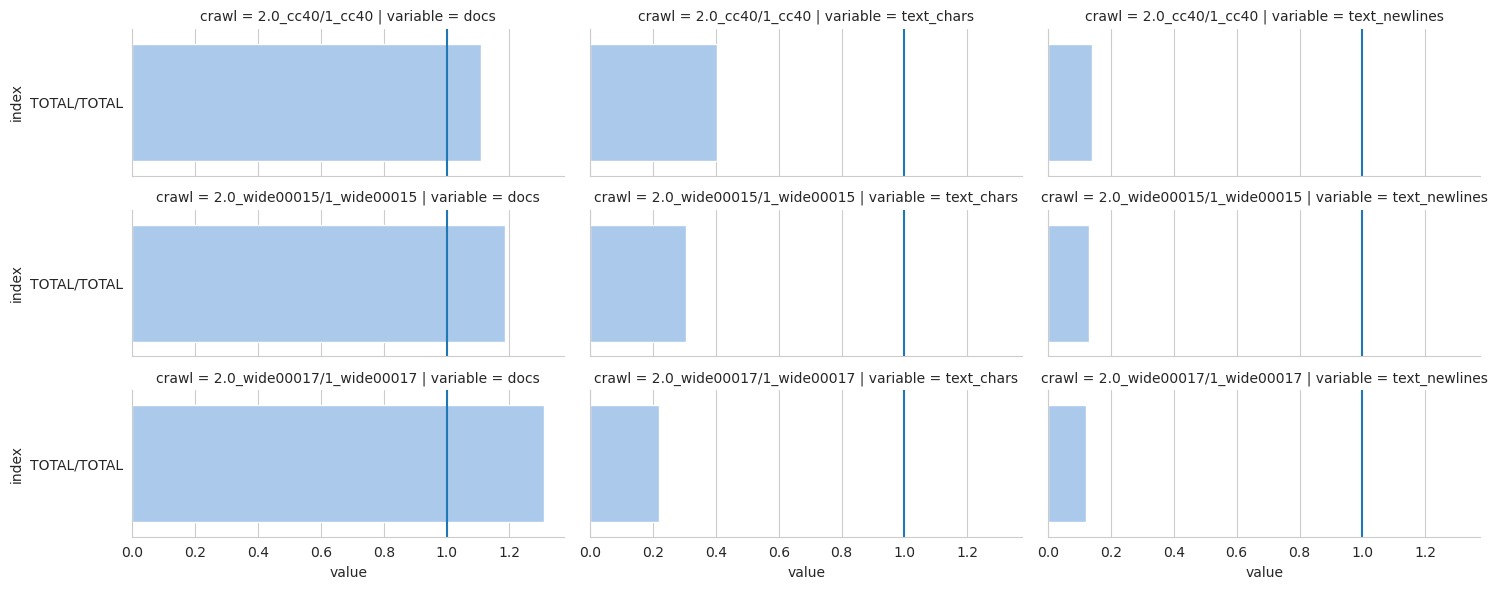

In [25]:
plots = [f'2.0_{c}/1_{c}' for c in ('cc40','wide00015','wide00017')]
plot_ratios(pdf[(pdf.lang=='TOTAL') &
    pdf.crawl.isin(plots)], row_order=plots, 
            height=2, aspect=2.5, save_path='_release1vs2/3crawls_ratios_1vs2_totals.pdf', log_base=0)

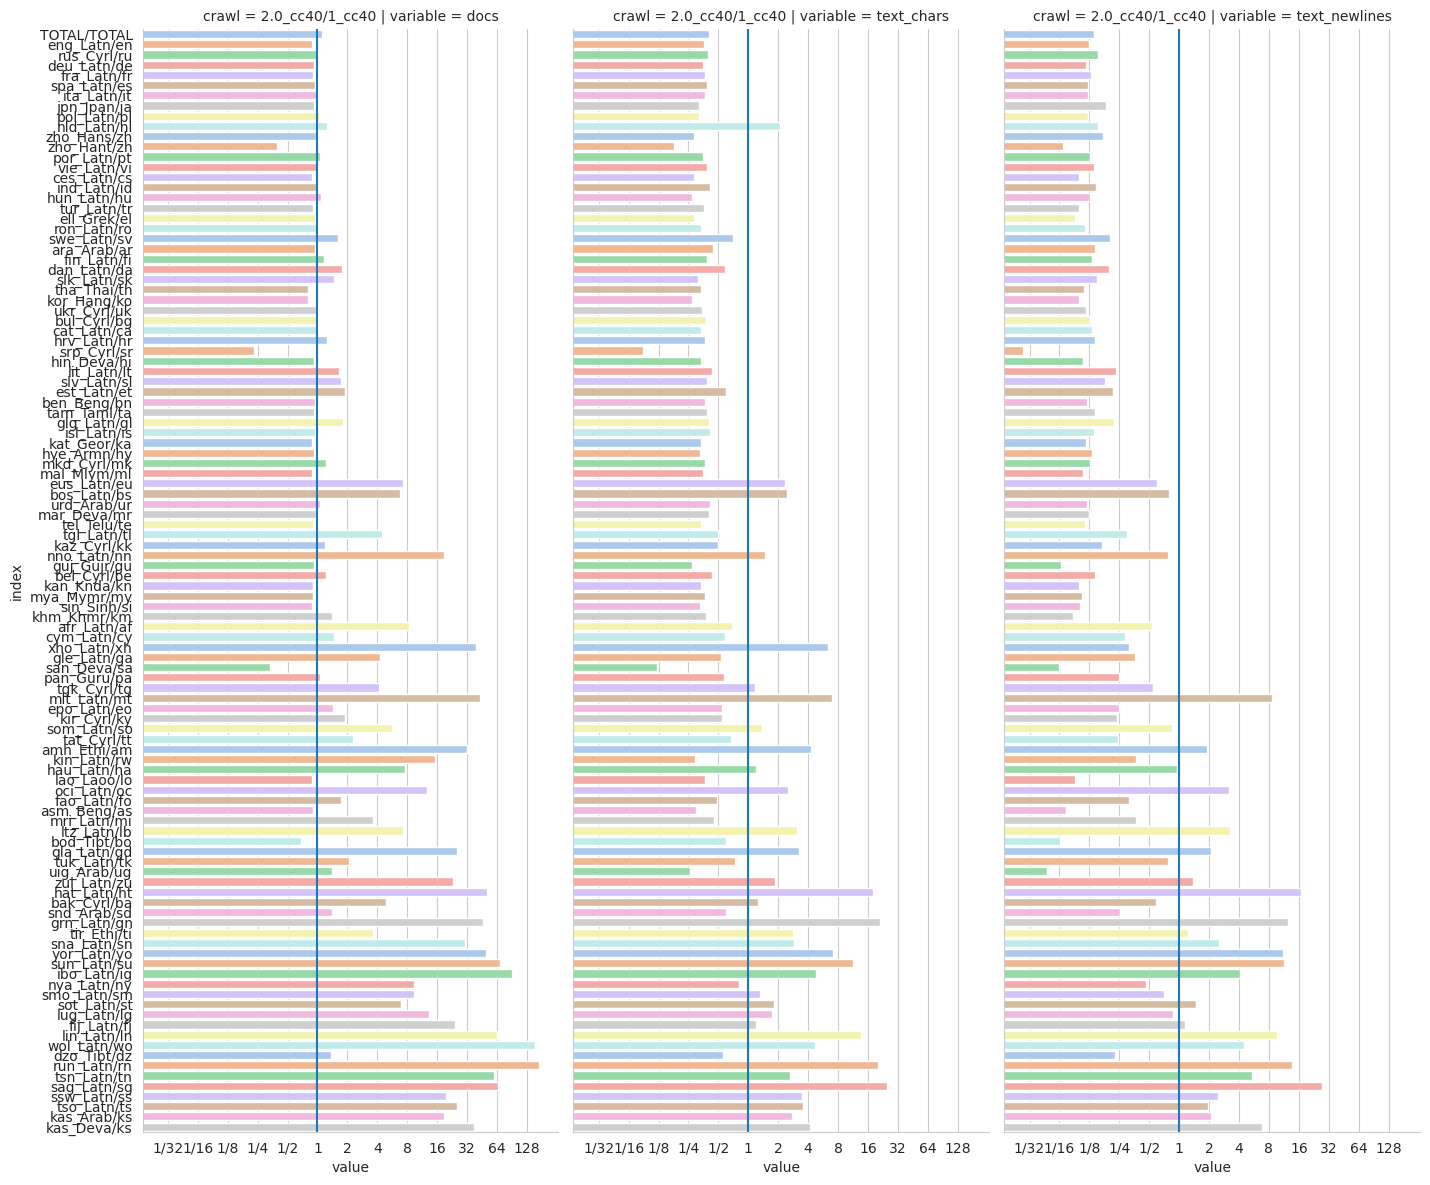

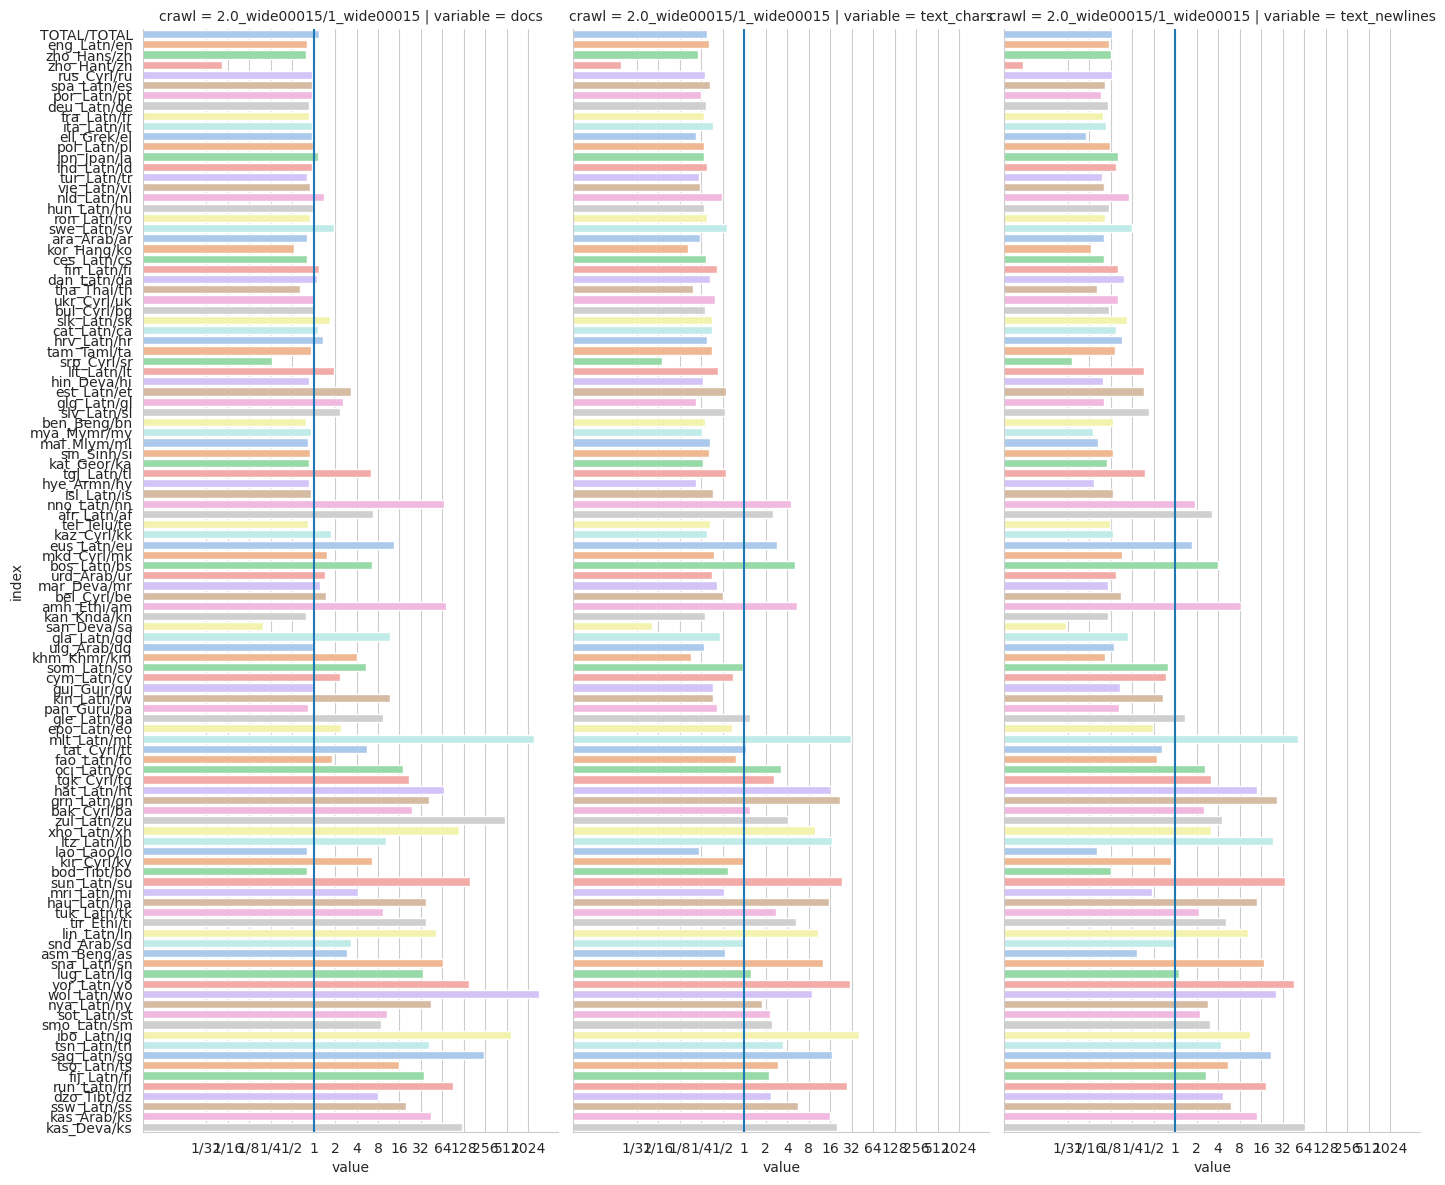

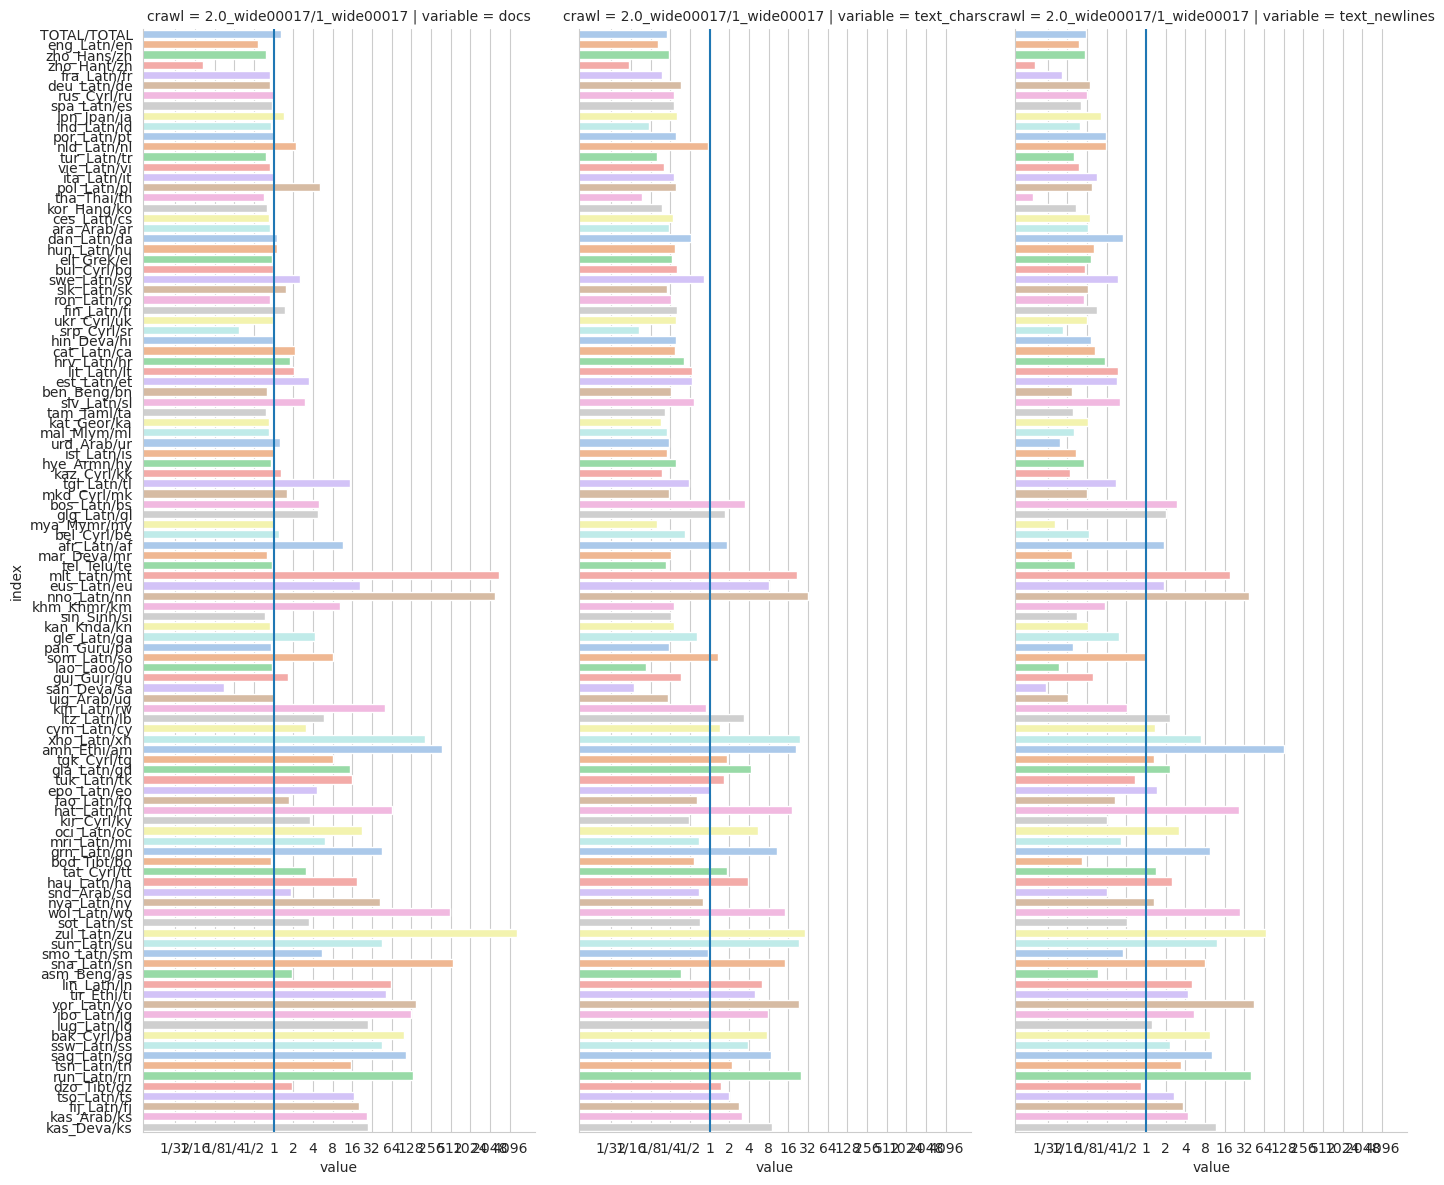

In [35]:
for crawl in ('cc40', 'wide00015', 'wide00017'):
    plot_ratios(pdf[pdf.crawl.isin([f'2.0_{crawl}/1_{crawl}'])], aspect=0.4,                
               save_path=f'_release1vs2/{crawl}_ratios_1vs2_wp2out_perlang.pdf')

# release1VS2 per language

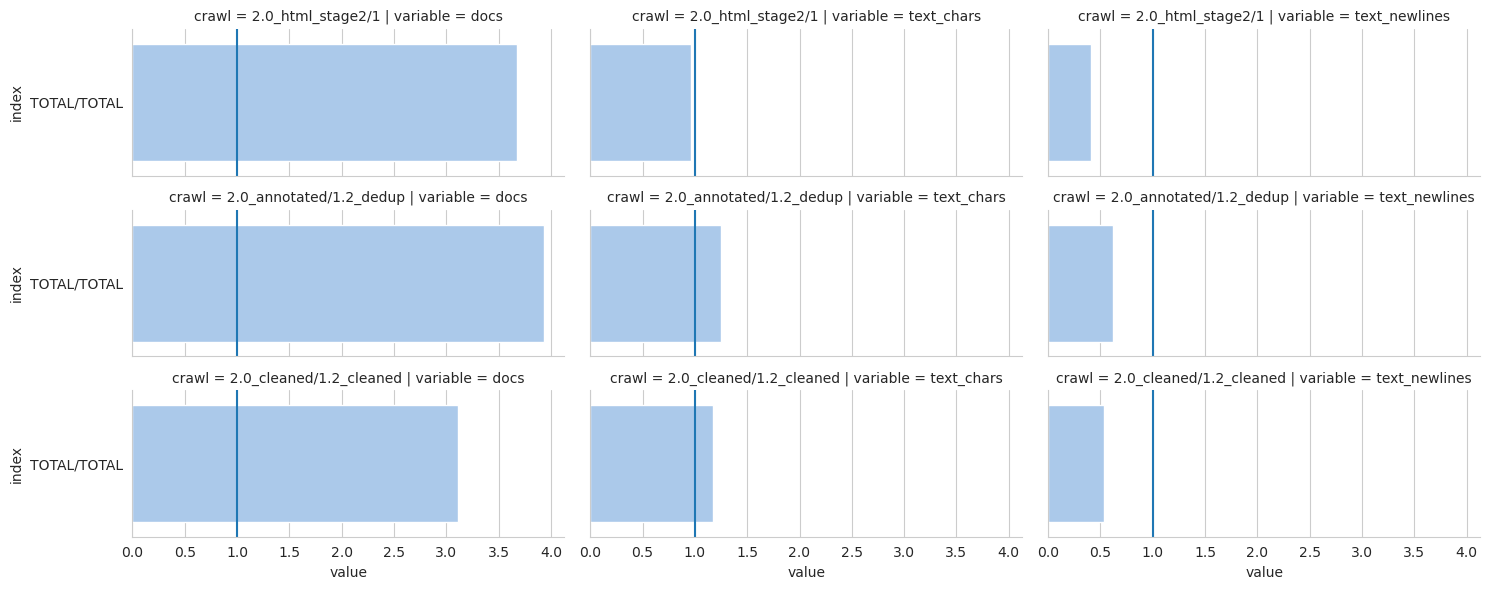

In [27]:
plots = '2.0_html_stage2/1 2.0_annotated/1.2_dedup 2.0_cleaned/1.2_cleaned'.split()
plot_ratios(pdf[(pdf.lang=='TOTAL') &
    pdf.crawl.isin(plots)], row_order=plots, 
            height=2, aspect=2.5, save_path='_release1vs2/ratios_1vs2_totals.pdf', log_base=0)

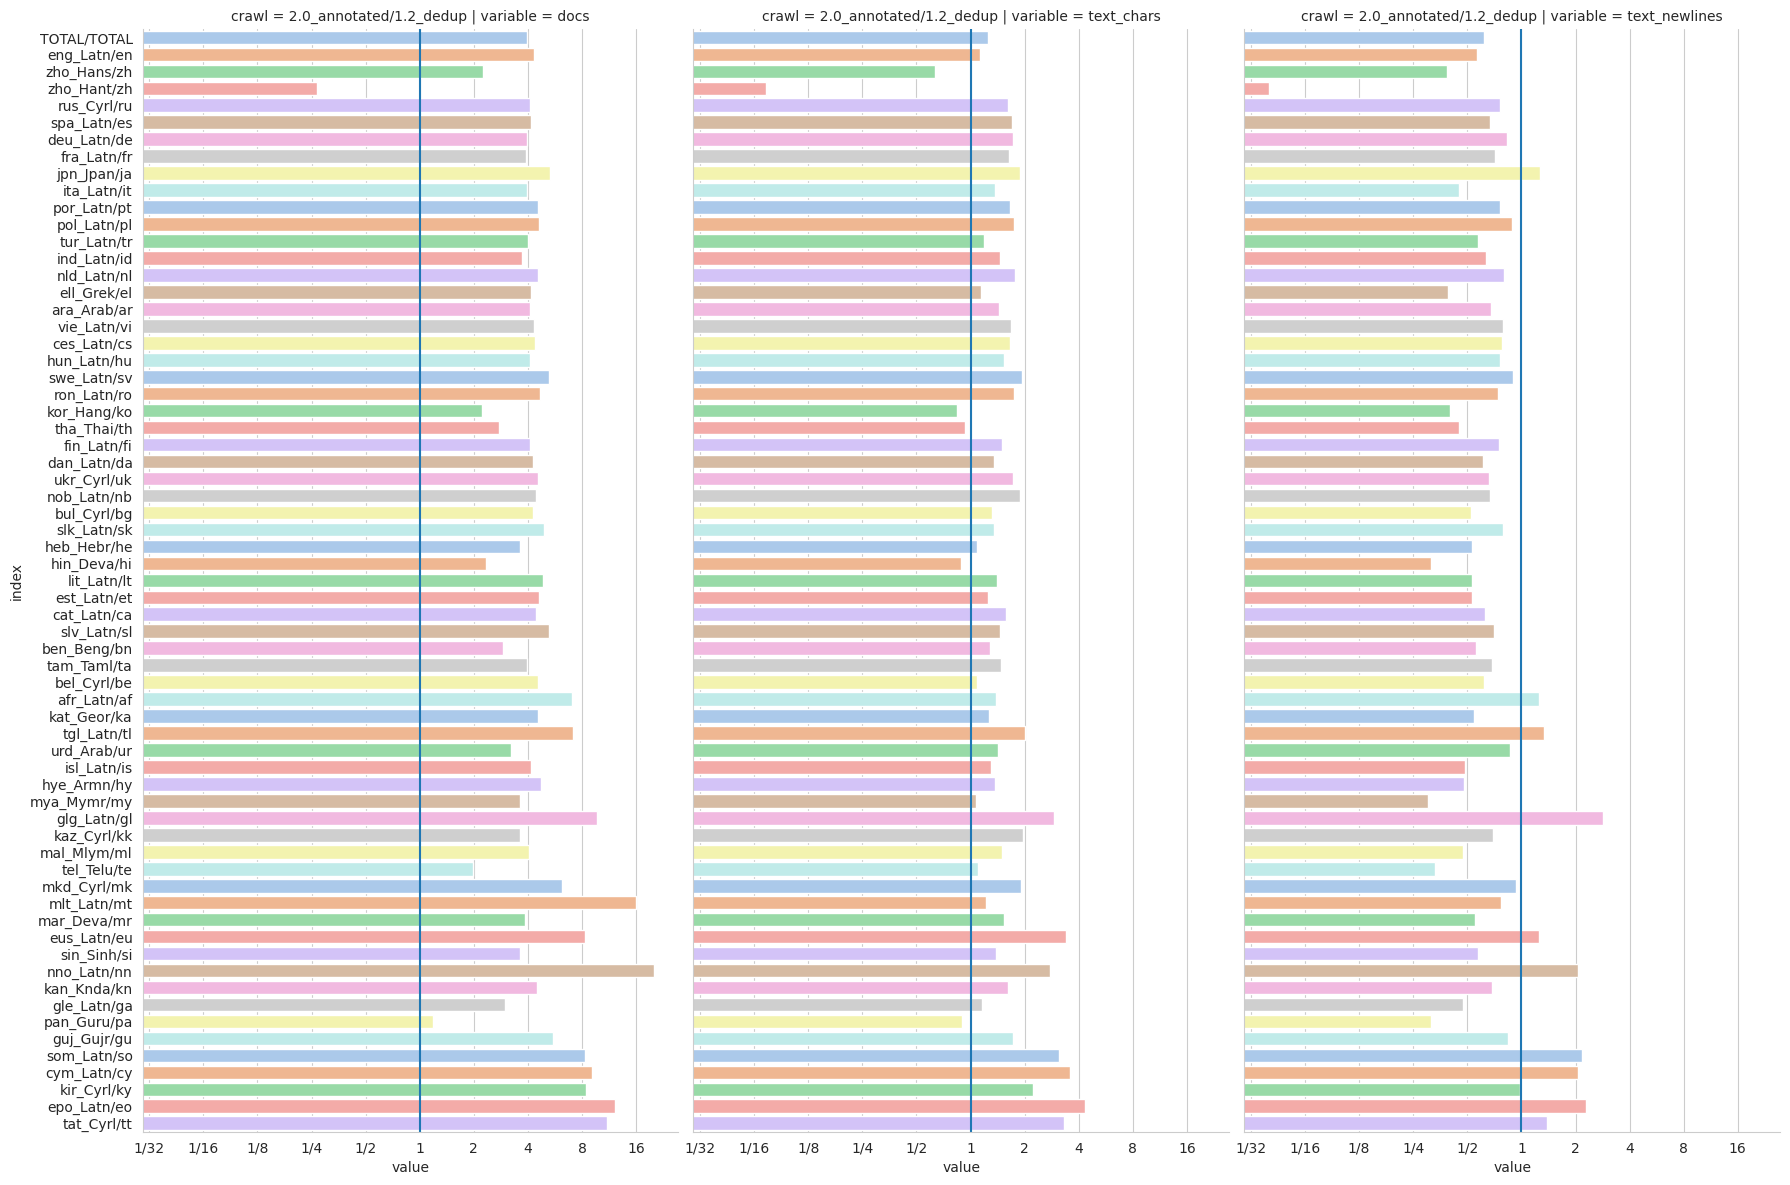

In [28]:
plot_ratios(pdf[pdf.crawl.isin(['2.0_annotated/1.2_dedup'])],
           save_path='_release1vs2/ratios_1vs2_dedup_perlang.pdf')

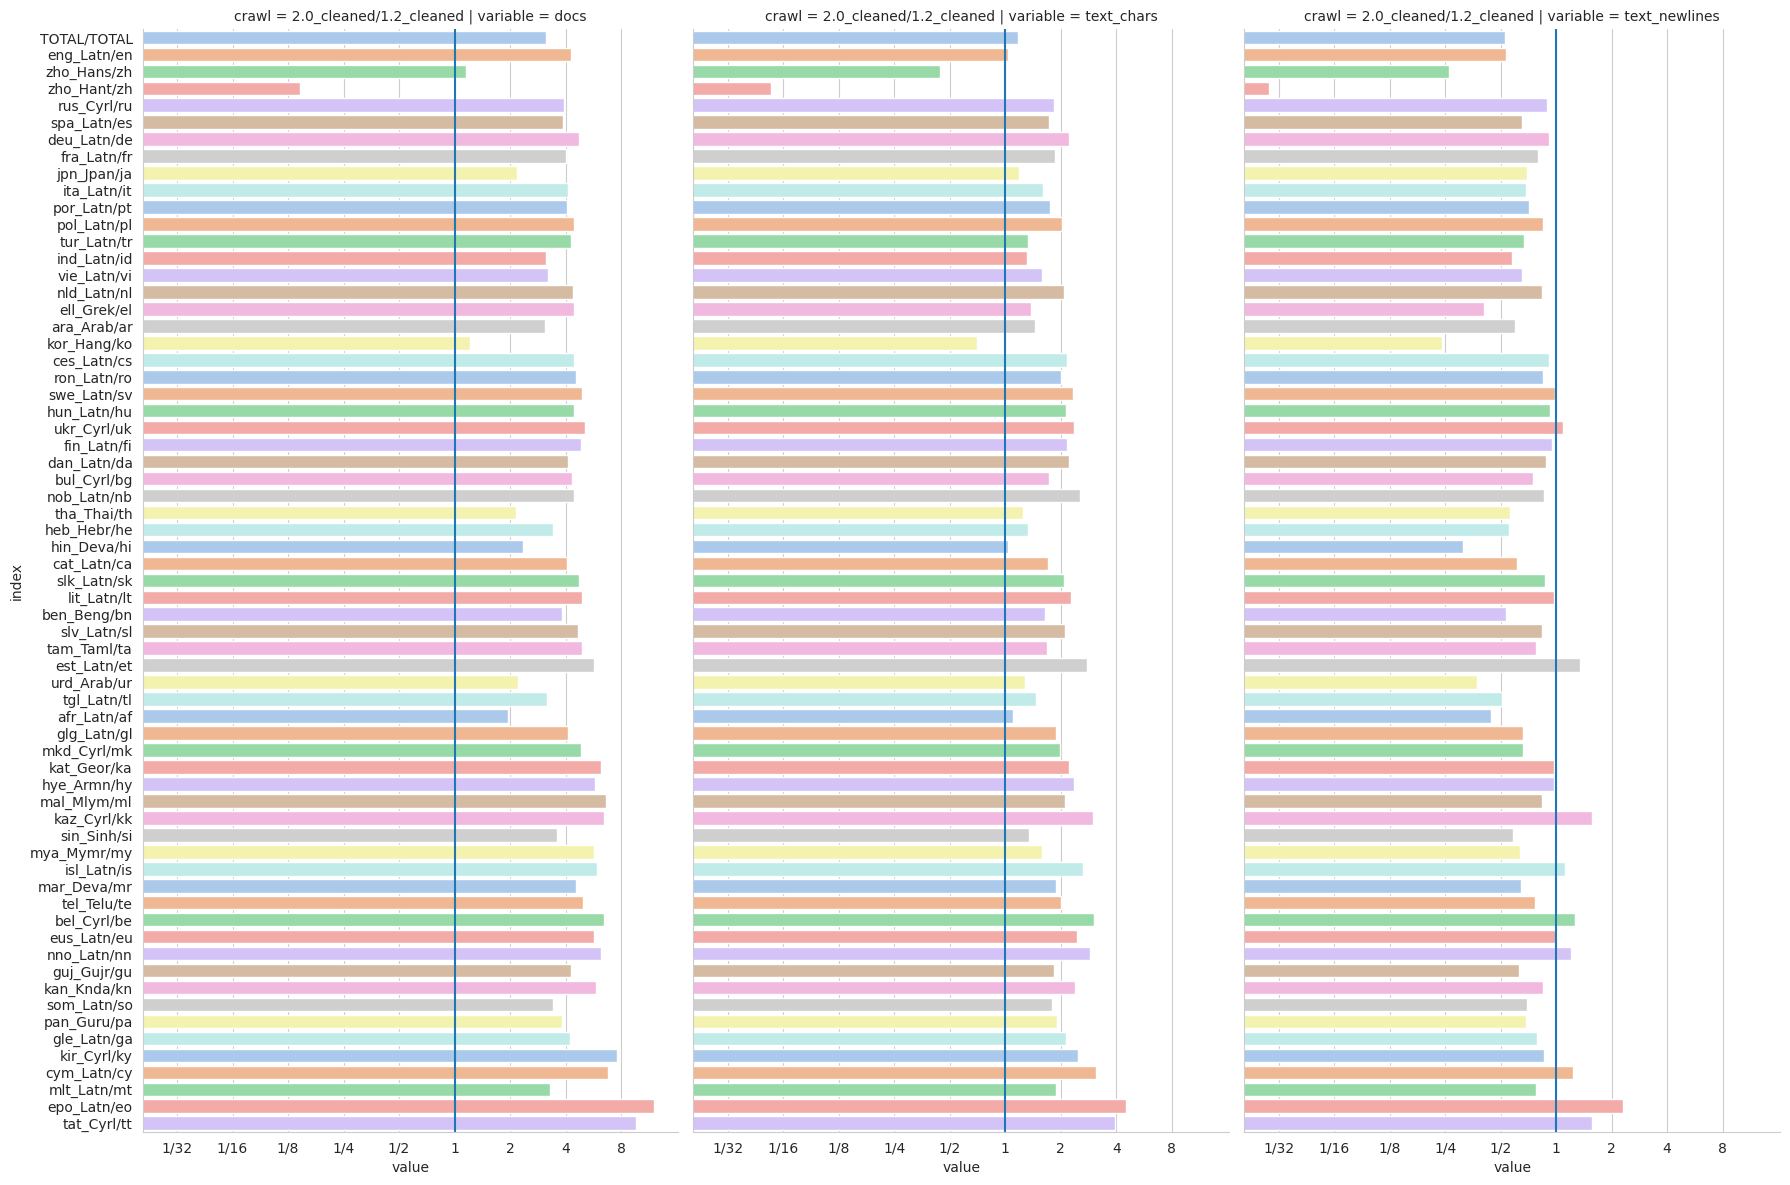

In [29]:
plot_ratios(pdf[pdf.crawl.isin(['2.0_cleaned/1.2_cleaned'])],
           save_path='_release1vs2/ratios_1vs2_cleaned_perlang.pdf')

# Comparing different processing stages for the same release

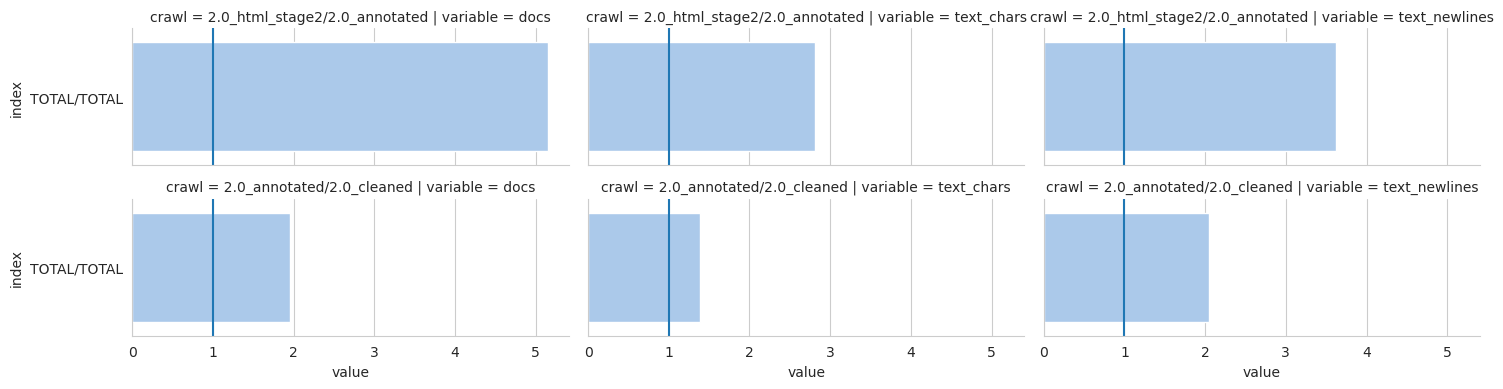

In [36]:
plots = '2.0_html_stage2/2.0_annotated 2.0_annotated/2.0_cleaned'.split()
plot_ratios(pdf[(pdf.lang=='TOTAL') &
    pdf.crawl.isin(plots)], row_order=plots, 
            height=2, aspect=2.5, save_path='_release1vs2/ratios_2steps_totals.pdf', log_base=0)

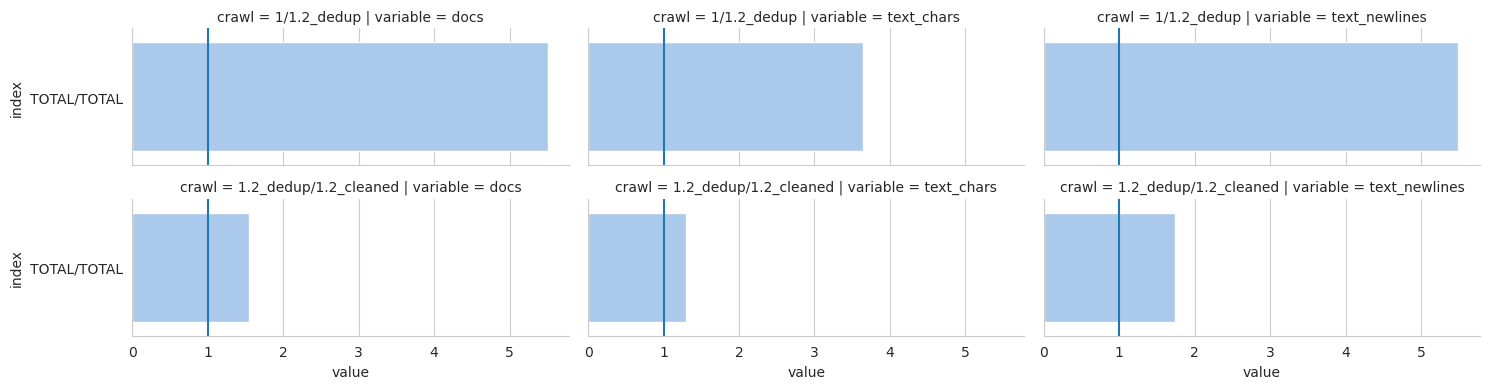

In [37]:
plots = '1/1.2_dedup 1.2_dedup/1.2_cleaned'.split()
plot_ratios(pdf[(pdf.lang=='TOTAL') &
    pdf.crawl.isin(plots)], row_order=plots, 
            height=2, aspect=2.5, save_path='_release1vs2/ratios_1steps_totals.pdf', log_base=0)

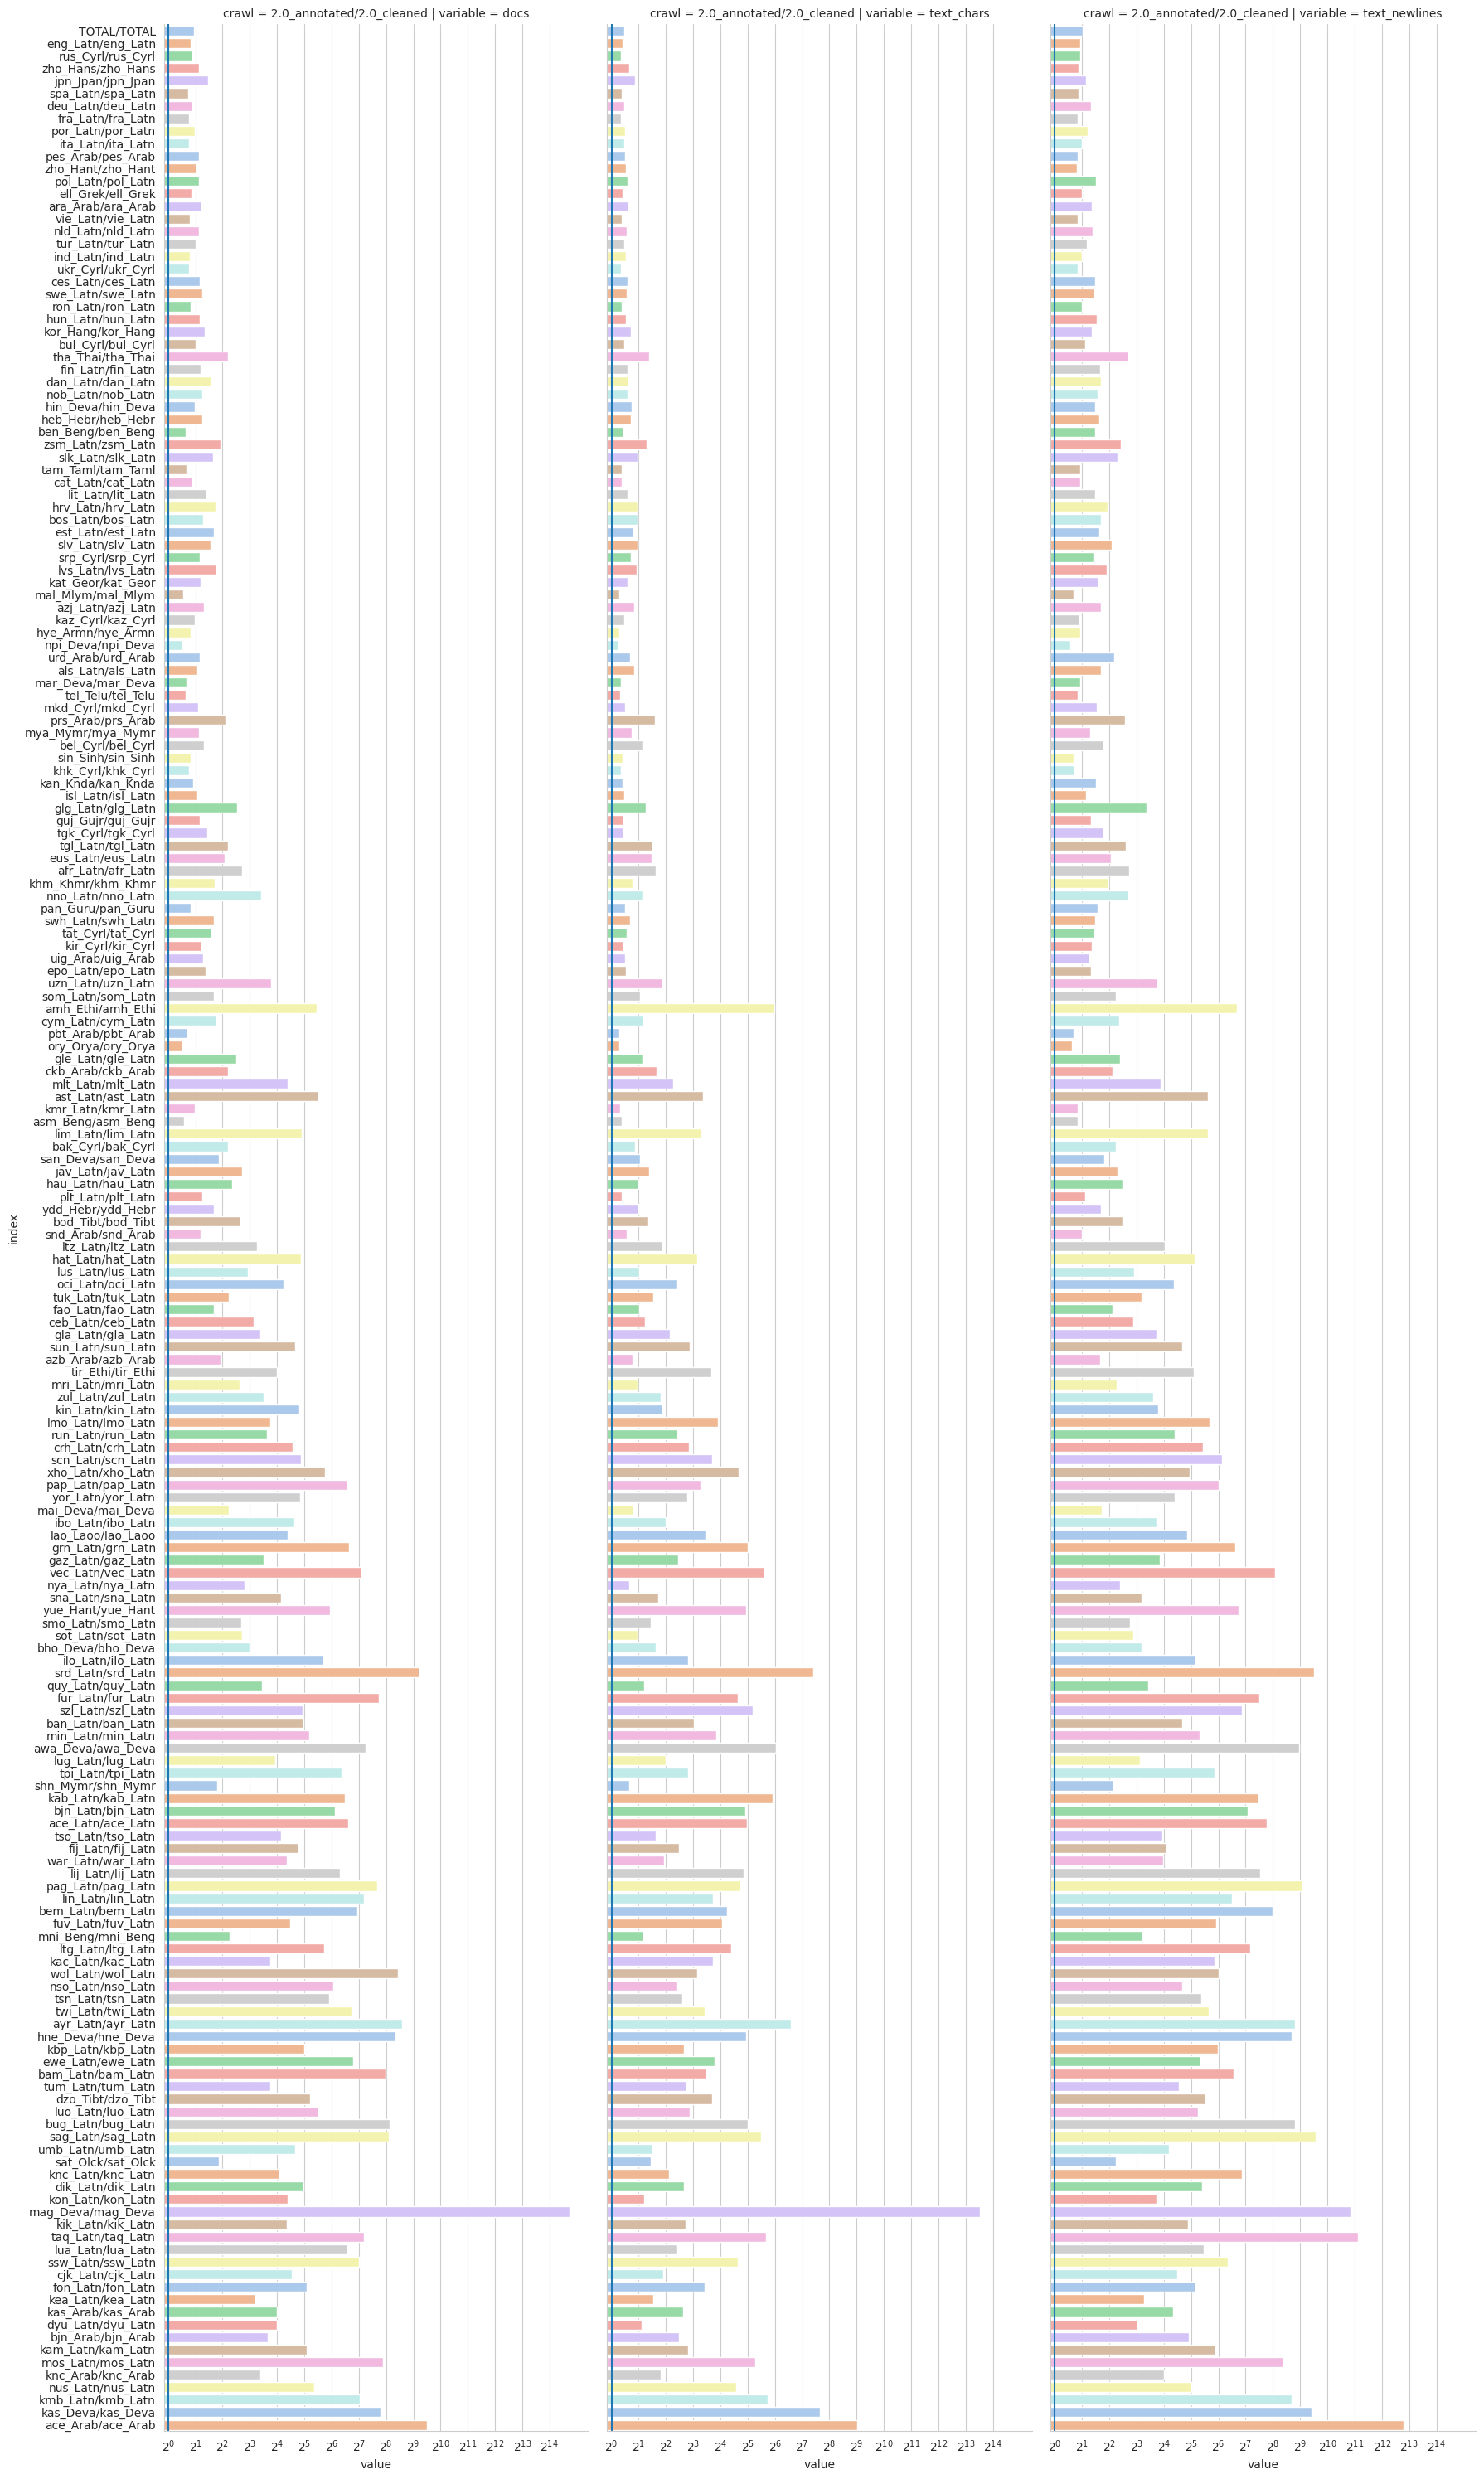

In [38]:
plot_ratios(pdf[pdf.crawl=='2.0_annotated/2.0_cleaned'], 
            height=30, aspect=0.2, save_path='_release1vs2/ratios_release2annotatedVScleaned_perlang.pdf')

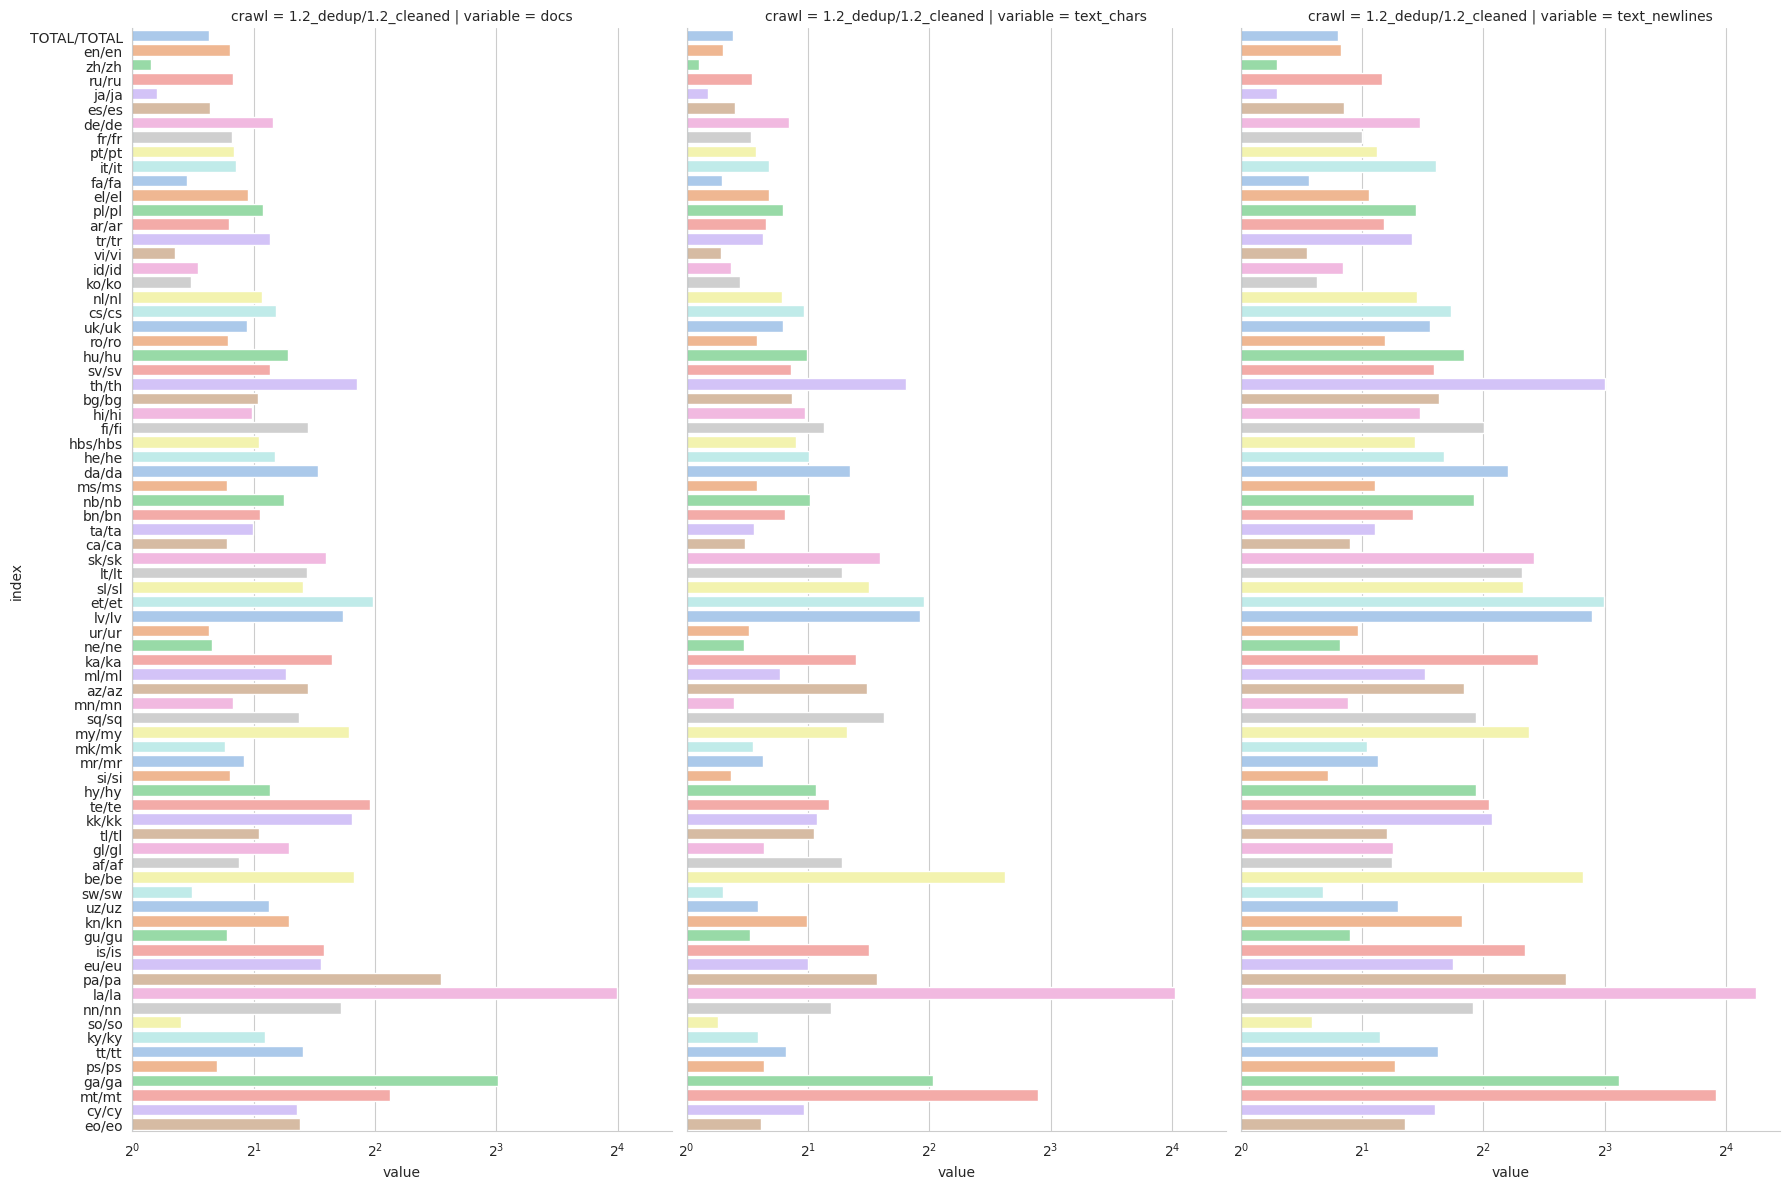

In [39]:
plot_ratios(pdf[pdf.crawl=='1.2_dedup/1.2_cleaned'], 
            height=12, aspect=0.5, save_path='_release1vs2/ratios_release1_dedupVScleaned.pdf')

# Sanity checks

In [129]:
pdf[pdf.crawl=='2.0_annotated/1.2_cleaned'].query('index=="azb_Arab/az"')

,index,lang,crawl,variable,value
232,azb_Arab/az,azb_Arab,2.0_annotated/1.2_cleaned,text_newlines,0.054452
840,azb_Arab/az,azb_Arab,2.0_annotated/1.2_cleaned,text_chars,0.052207
1448,azb_Arab/az,azb_Arab,2.0_annotated/1.2_cleaned,docs,0.230904


In [128]:
1/16

0.0625

# Compare extracted docs, chars per crawl